In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from project1.Implemented_functions import *
from project1.Cleaning_functions import *
from project1.helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data

In [2]:
X_train_data_full, X_test_data, Y_train_data_full, train_ids, test_ids = load_csv_data("data\dataset\dataset")
print("X_train_data shape:", X_train_data_full.shape)
print("Y_train_data shape:", Y_train_data_full.shape)
print("X_test_data shape:", X_test_data.shape)

<>:1: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:1: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\janfo\AppData\Local\Temp\ipykernel_3200\4294577664.py:1: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
  X_train_data_full, X_test_data, Y_train_data_full, train_ids, test_ids = load_csv_data("data\dataset\dataset")


X_train_data shape: (328135, 321)
Y_train_data shape: (328135,)
X_test_data shape: (109379, 321)


In [3]:
print("Number of -1 labels in Y_train_data:", np.sum(Y_train_data_full == -1))
print("Number of 1 labels in Y_train_data:", np.sum(Y_train_data_full == 1))
Y_train_data_norm_full = np.where(Y_train_data_full == -1, 0, Y_train_data_full)
print("Number of -1 labels in Y_train_data_norm:", np.sum(Y_train_data_norm_full == -1))

X_train_data, Y_train_data = X_train_data_full, Y_train_data_norm_full

Number of -1 labels in Y_train_data: 299160
Number of 1 labels in Y_train_data: 28975
Number of -1 labels in Y_train_data_norm: 0


In [5]:
"Run if needed to reduce dataset size for faster testing"
# X_train_data, Y_train_data = X_train_data_full[:10000], Y_train_data_norm_full[:10000]
print("Reduced X_train_data shape:", X_train_data.shape)
print("Reduced Y_train_data shape:", Y_train_data.shape)

Reduced X_train_data shape: (328135, 321)
Reduced Y_train_data shape: (328135,)


# New models, feature selection and regularization
In this model script, as we already explored some data preprocessing mesures, we will try to implement more clever strategies to manage the data preprocessing and feature selection. Moreover, we will dicuss if regularization is needed and, in case it is, the best way to do so.

# Best Logistic Regularization
In this section we will explore the different values for the lambda parameter for the logistic model. From now, we will consider the preprocessing data fixed, as we ended the Model_I script: standardize, more than 75% NaN features removed, balancing (turn data into 50 % for each label) and NaN substitution by the mean. 

In [9]:
# Preprocessing

def preprocessing(x_train, x_val, y_train, y_val, threshold=0.75): # fix 75%
    
    # remove features that contain NaN values in the training set
    x_train, keep_mask = remove_nan_features(x_train, threshold=threshold) # we remove features with more than 30% NaN values
    x_val = x_val[:, keep_mask]
    # replace missing values with mean and standardize features
    x_train = impute_missing_values(x_train, strategy='mean')
    x_val = impute_missing_values(x_val, strategy='mean')
    x_train, means, stds = standardize_features(x_train)
    x_val = (x_val - means) / stds
    # balance data by undersampling, so that both classes have the same number of samples
    x_train, y_train = balance_data(x_train, y_train, method='undersample')
    print("Number of removes features due to NaN values:", np.sum(~keep_mask))
    return x_train, x_val, y_train, y_val

First we try some lambdas and plot the learning curve to capture the behaviour. 

In [ ]:
# This cell takes a lot of time to run. Better to skip it and run the next one to load the stored results

m = X_train_data.shape[0] // 5
X_train_over, X_val_over = X_train_data[m:], X_train_data[:m]
Y_train_over, Y_val_over = Y_train_data[m:], Y_train_data[:m]


lambdas = [0., 1e-6, 1e-3, 1.]
train_losses_lambdas, val_losses_lambdas, f1s_lambdas = [], [], []

for lambda_ in lambdas:

    def train_method(y, x):  
        return logistic_regression_penalized_gradient_descent(y, x, gamma = 0.5, lambda_ =lambda_)
    def evaluator(y, x, w):
        return evaluate_logistic_model(y, x, w, threshold=0.7, lambda_ = lambda_) # we saw in Model_I that 0.7 was the best for this preprocess

    train_losses, val_losses, f1s_datasize, N = over_under_fitting(
        X_train_over, 
        X_val_over, 
        Y_train_over, 
        Y_val_over, 
        train_method = train_method, 
        evaluator = evaluator, preprocess=preprocessing, steps = 20)
    train_losses_lambdas.append(train_losses)
    val_losses_lambdas.append(val_losses)
    f1s_lambdas.append(f1s_datasize)
    print("For lambda:", lambda_, "best f1:", max(f1s_datasize))

Before preprocess (262508, 321) (262508,)


MemoryError: Unable to allocate 513. GiB for an array with shape (262508, 262508) and data type float64

In [ ]:
# code to save the results of the exploration 

""""
print(train_losses_lambdas, val_losses_lambdas, f1s_datasize)

l1 = np.array(train_losses_lambdas)
l2 = np.array(val_losses_lambdas)
l3 = np.array(f1s_lambdas)

np.savez('LearningCurveArrays.npz', a=l1, b=l2, c=l3)
"""

[[0.47782293775991824, 0.47698732355355455, 0.4769797667913417, 0.4770039175573837, 0.47681266868960714, 0.4773146148510138, 0.47865607094187657, 0.4796717078395382, 0.4782240867822293, 0.47912594239435036, 0.47835353433693933, 0.479596962621177, 0.4779949204257517, 0.4765741103326543, 0.47627971060157254, 0.4765373725837642, 0.4765373725837642, 0.4765373725837642, 0.4765373725837642, 0.4765373725837642], [0.46913751205520937, 0.46864342411863963, 0.46933432814373377, 0.46957572959533184, 0.47013088621710947, 0.47271475825321124, 0.4726492327593902, 0.47231070965972555, 0.4732384067332979, 0.4731435062442052, 0.47239630488329915, 0.471653605361771, 0.4740681027608305, 0.4742306367302612, 0.4742400949416812, 0.47425435810150346, 0.47425435810150346, 0.47425435810150346, 0.47425435810150346, 0.47425435810150346], [0.4677932052993417, 0.46926186000038683, 0.469717432554358, 0.47062807892668707, 0.47090624003003345, 0.47217401655926633, 0.4722353018003547, 0.4725857994053359, 0.47421844351

In [10]:
# Run this to get the results loaded

m = X_train_data.shape[0] // 5
X_train_over, X_val_over = X_train_data[m:], X_train_data[:m]
Y_train_over, Y_val_over = Y_train_data[m:], Y_train_data[:m]
X_train_over, X_val_over, _, _  = preprocessing(X_train_over, X_val_over, Y_train_over, Y_val_over, threshold=0.75)

N = X_train_over.shape[0] # The largest datasize used in the learning curve generator

lambdas = [0., 1e-6, 1e-3, 1.]

data = np.load('LearningCurveArrays.npz')
l1_loaded = data['a']
l2_loaded = data['b']
l3_loaded = data['c']



Number of removes features due to NaN values: 117


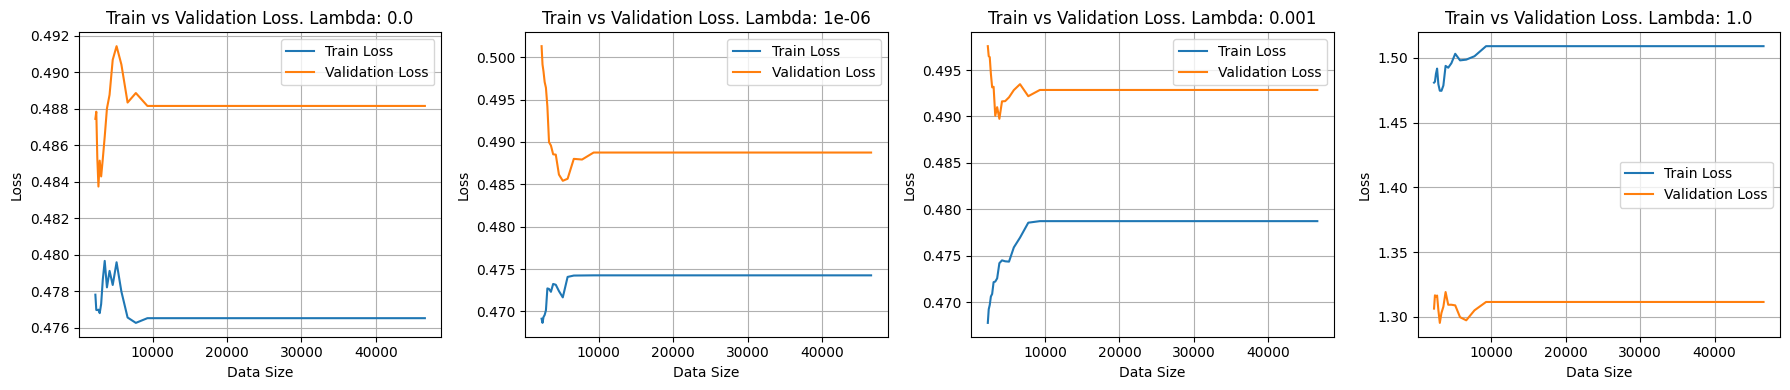

In [10]:
# Plot the results for the losses

data_sizes = np.array([N / (len(l1_loaded[0]) - i) for i in range(len(l1_loaded[0]))])

fig, axs = plt.subplots(1, len(lambdas), figsize=(18, 4)) 

for i in range(len(lambdas)):

    axs[i].plot(data_sizes, l1_loaded[i], label='Train Loss')
    axs[i].plot(data_sizes, l2_loaded[i], label='Validation Loss')
    axs[i].set_title(f'Train vs Validation Loss. Lambda: {lambdas[i]}')
    axs[i].set_ylabel('Loss')
    axs[i].set_xlabel('Data Size')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

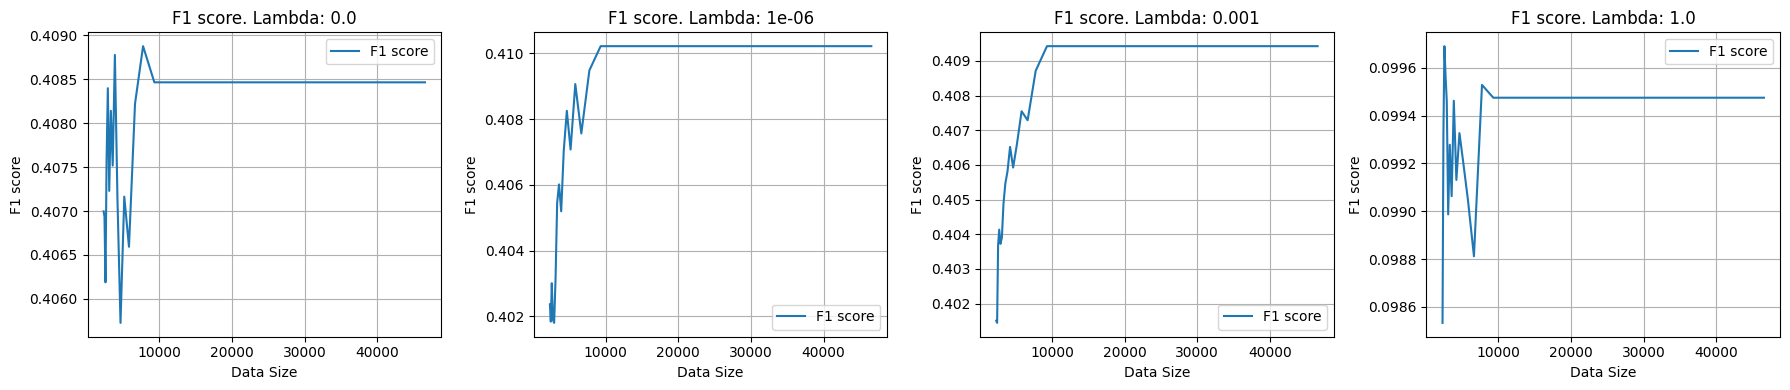

In [11]:
# Plot for the F1 scores

N = X_train_over.shape[0]
data_sizes = np.array([N / (len(l1_loaded[0]) - i) for i in range(len(l1_loaded[0]))])

fig, axs = plt.subplots(1, len(lambdas), figsize=(18, 4)) 

for i in range(len(lambdas)):

    axs[i].plot(data_sizes, l3_loaded[i], label='F1 score')
    axs[i].set_xlabel('Data Size')
    axs[i].set_ylabel('F1 score')
    axs[i].set_title(f'F1 score. Lambda: {lambdas[i]}')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()


In [12]:
# Print a summary
N = X_train_over.shape[0]
data_sizes = np.array([N / (len(l1_loaded[0]) - i) for i in range(len(l1_loaded[0]))])


print("Summary")
for i in range(len(lambdas)):
    print("For lambda", lambdas[i], "best F1 score:", np.max(l3_loaded[i]), "in iteration", data_sizes[np.argmax(l3_loaded[i])])

Summary
For lambda 0.0 best F1 score: 0.40887835899993713 in iteration 7760.666666666667
For lambda 1e-06 best F1 score: 0.41022142281213125 in iteration 9312.8
For lambda 0.001 best F1 score: 0.4094252586959227 in iteration 9312.8
For lambda 1.0 best F1 score: 0.09969056908381495 in iteration 2586.8888888888887


This plots suggest that maybe more flexibility is needed in our model. To do so, we will implement a new approach for categorical features

# Categorical and numerical features
In this section, we will preprocess categorical and numerical features differently. Each categorical feature will be replaced by k−1 indicator variables, and missing values will be imputed with the mode for categorical features and with the mean for numerical ones. This approach increases the model's flexibility, as it allows different coefficients for the same categorical variable. We replace NaN values in categorical features with the mode because, if we consider the feature as a discrete random variable, the mean might not correspond to a possible category

In [86]:
# Define preprocessing function

def preprocess_feature_types(X_train, X_valid, Y_train, Y_valid):
    """
    Args:
        X_train: data as it is loaded from csv. No balanced labels
        Y_train: labels 1 and 0 without balance. 
        X_valid: data as it is loaded from csv. No balanced labels
        Y_valid: labels 1 and 0 without balance. 

    Returns:
        X_train_preprocessed: 
        Y_train_preprocessed: 
        X_valid_preprocessed: 
        Y_valid_preprocessed: 
    """

    # Tuning parameter section
    NaN_removal_threshold = 0.75

    # Balance labels

    X_train, Y_train = balance_data(X_train, Y_train, method='undersample') # only balance training

    # Remove high desnity NaN features

    X_train, NaN_removal_features_mask = remove_nan_features(X_train, threshold=NaN_removal_threshold)

    # Detect categorical
    X_valid = X_valid[:, NaN_removal_features_mask]
    cat_mask, num_mask = detect_features_type(X_train, max_unique=10)

    # Numerical NaN substitution with means
    
    X_train, means = impute_numerical(X_train, num_mask, strategy= 'means')
    X_valid, _ = impute_numerical(X_valid, num_mask, means = means, strategy = 'means')

    # Categorical NaN substitution (compute modes from training)
    X_train, modes = impute_categorical(X_train, cat_mask)
    X_valid, _ = impute_categorical(X_valid, cat_mask, modes)

    # Fit one-hot encoder on training data. Now we are adding features

    print("Number of features before one-hot encoder:", X_train.shape[1])
    X_train, categories = one_hot_encode(X_train, cat_mask, drop_first=True)
    X_valid, _ = one_hot_encode(X_valid, cat_mask, categories, drop_first=True)
    print("Number of features after one-hot encoder:", X_train.shape[1])

    cat_mask_enc, num_mask_enc = detect_features_type(X_train, max_unique=10)

    # standarize only the numerical features
    X_train, means, stds = standardize_features(X_train, num_mask_enc)
    X_valid, _, _ = standardize_features(X_valid, num_mask_enc, means, stds)

    return X_train, X_valid, Y_train, Y_valid


In [12]:
# Check dimensionality change 

m = X_train_data.shape[0] // 5
X_train_over, X_val_over = X_train_data[m:], X_train_data[:m]
Y_train_over, Y_val_over = Y_train_data[m:], Y_train_data[:m]


print("Shapes before preprocessing", X_train_over.shape, Y_train_over.shape)
X1, X2, Y1, Y2 = preprocess_feature_types(
    X_train_over,  
    X_val_over, 
    Y_train_over,
    Y_val_over)
print("Shapes after preprocessing", X1.shape, X2.shape, Y1.shape, Y2.shape)

N = X1.shape[0]

Shapes before preprocessing (262508, 321) (262508,)
Number of features before one-hot encoder: 203
Number of features after one-hot encoder: 488
Shapes after preprocessing (46564, 488) (65627, 488) (46564,) (65627,)


## Gamma choice
As we are using a model with more complexity, it is necessary to try to find the best training gamma, as we will see that for big gammas we don't converge and for small gammas we can't reach the minimum in the steps limit. 

In [45]:
# cross validation to select best gamma
# this cell takes some time to run. Better to run the next one and load the results

gammas = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
f1s_gamma = []
accs_gama = []

for gamma in gammas:

    acc, f1 = kfold_logistic_ridge(
        X_train_data, Y_train_data, 
        preprocess_feature_types,   # we use here the new preprocessing
        k=5, gamma=gamma, lambda_=1e-3,  # put gamma as a parameter
        alpha = 0.7 , threshold=1e-5, random_state=True)
    
    f1s_gamma.append(f1)
    accs_gama.append(acc)

Start cleaning batch 1 out of 5
Number of features before one-hot encoder: 203
Number of features after one-hot encoder: 486
Cleaning of batch 1 done. Stating the model training.
Iteration     0, loss = 0.693147
Iteration   100, loss = 0.491554
Iteration   200, loss = 0.482293
Iteration   300, loss = 0.478219
Iteration   400, loss = 0.475763
Iteration   500, loss = 0.474081
Iteration   600, loss = 0.472854
Iteration   700, loss = 0.471927
Iteration   800, loss = 0.471209
Iteration   900, loss = 0.470642
Iteration  1000, loss = 0.470189
Iteration  1100, loss = 0.469823
Iteration  1200, loss = 0.469523
Iteration  1300, loss = 0.469276
Iteration  1400, loss = 0.469070
Iteration  1500, loss = 0.468898
Iteration  1600, loss = 0.468753
Iteration  1700, loss = 0.468630
Iteration  1800, loss = 0.468525
Iteration  1900, loss = 0.468435
Iteration  2000, loss = 0.468357
Iteration  2100, loss = 0.468290
Iteration  2200, loss = 0.468231
Iteration  2300, loss = 0.468180
Iteration  2400, loss = 0.468

In [ ]:
# code to save the results of the exploration 

"""
print(f1s_gamma, accs_gama)

l1 = np.array(f1s_gamma)
l2 = np.array(accs_gama)

np.savez('GammaChoiceFeatureTypePreprocess.npz', a=l1, b=l2)
"""

[np.float64(0.4244314000667259), np.float64(0.4243244726890434), np.float64(0.42436388083778703), np.float64(0.42429433869650507), np.float64(0.381763420302141), np.float64(0.3331371271930223), np.float64(0.30999432549501743)] [np.float64(0.8609870937266674), np.float64(0.8609444283602784), np.float64(0.8609505234126198), np.float64(0.8609352857817667), np.float64(0.7765675712740183), np.float64(0.6890426196534963), np.float64(0.6424642296615721)]


In [47]:
# Run this to get the results loaded

gammas = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
data = np.load('GammaChoiceFeatureTypePreprocess.npz')
f1s_gamma_loaded = data['a']
accs_gamma_loaded = data['b']

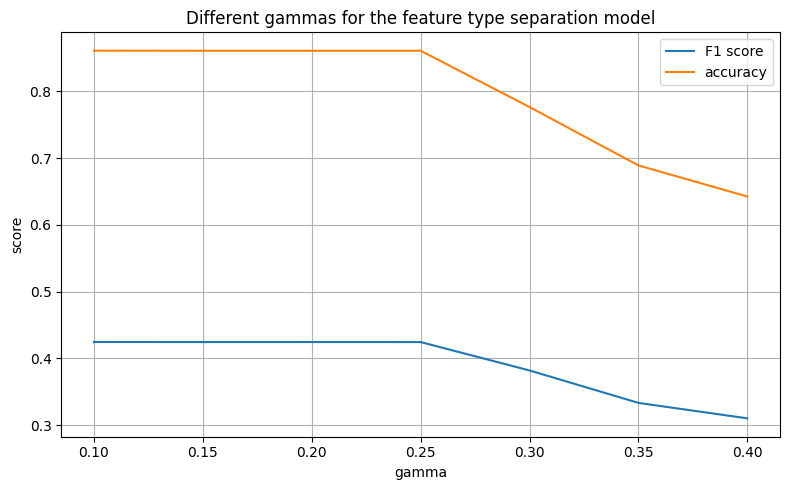

Best F1 score 0.4244314000667259 for gamma: 0.1


In [50]:
# plot the results

plt.figure(figsize=(8, 5))
plt.plot(gammas, f1s_gamma_loaded, label='F1 score')
plt.plot(gammas, accs_gamma_loaded, label= "accuracy")
plt.xlabel('gamma')
plt.ylabel('score')
plt.title("Different gammas for the feature type separation model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Best F1 score", np.max(f1s_gamma_loaded), "for gamma:", gammas[np.argmax(f1s_gamma_loaded)])

We detect a good gamma if the training loss gets stucked at the final iterations. So, from now on, we will take the gamma without a grid search, just by looking at the losses for some trainings. As we see, the F1 score with this preprocessing is way better than the one without the features type division.

## Learning curve for the feature type separation model
Now that we have a good gamma for this new model, we are abel to see if we have overfitting or underfitting with the hiperparameter lambda

In [94]:
# Define train method and evaluator. We use the best parameters seen until now.

def train_method(y, x):  
    return logistic_regression_penalized_gradient_descent(y, x, gamma = 0.1, lambda_ = 1e-6) 
    # Set lambda 1e-6 due to Model_I
    # Set gamma = 0.1 as we just saw
def evaluator(y, x, w):
    return evaluate_logistic_model(y, x, w, threshold=0.7, lambda_ = 1e-6) 
    # Set alpha threshold 70% due to Model_I

In [95]:
m = X_train_data.shape[0] // 5
X_train_over, X_val_over = X_train_data[m:], X_train_data[:m]
Y_train_over, Y_val_over = Y_train_data[m:], Y_train_data[:m]


train_losses, val_losses, f1s_datasize, N = over_under_fitting(
    X_train_over, 
    X_val_over, 
    Y_train_over, 
    Y_val_over, 
    train_method = train_method, 
    evaluator = evaluator, preprocess=preprocess_feature_types, steps = 8)

Before preprocess (262508, 321) (262508,)
Number of features before one-hot encoder: 203
Number of features after one-hot encoder: 488
After preprocess (46564, 488) (46564,)
n_i 5820
Iteration     0, loss = 0.693147
Iteration   100, loss = 0.477436
Iteration   200, loss = 0.466200
Iteration   300, loss = 0.460442
Iteration   400, loss = 0.456622
Iteration   500, loss = 0.453819
Iteration   600, loss = 0.451651
Iteration   700, loss = 0.449917
Iteration   800, loss = 0.448493
Iteration   900, loss = 0.447301
Iteration  1000, loss = 0.446288
Iteration  1100, loss = 0.445415
Iteration  1200, loss = 0.444654
Iteration  1300, loss = 0.443984
Iteration  1400, loss = 0.443389
Iteration  1500, loss = 0.442856
Iteration  1600, loss = 0.442376
Iteration  1700, loss = 0.441941
Iteration  1800, loss = 0.441544
Iteration  1900, loss = 0.441180
Iteration  2000, loss = 0.440845
Iteration  2100, loss = 0.440534
Iteration  2200, loss = 0.440245
Iteration  2300, loss = 0.439976
Iteration  2400, loss = 0

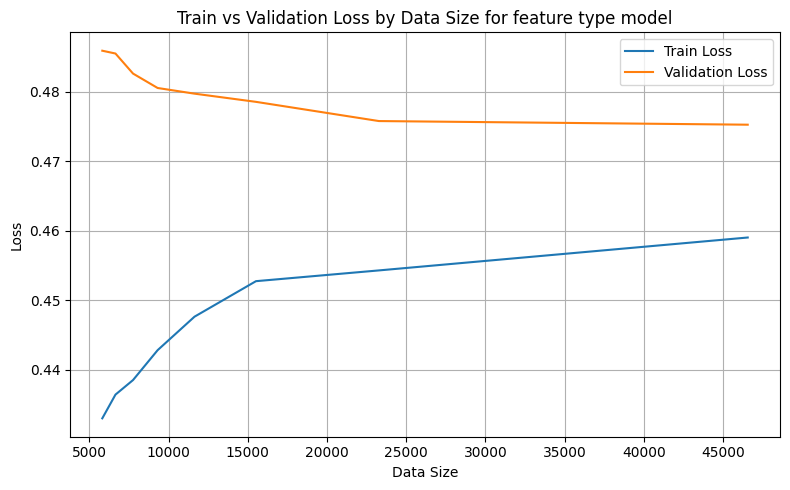

In [96]:
data_sizes = np.array([N / (len(train_losses) - i) for i in range(len(train_losses))])

plt.figure(figsize=(8, 5))
plt.plot(data_sizes, train_losses, label='Train Loss')
plt.plot(data_sizes, val_losses, label='Validation Loss')


plt.xlabel('Data Size')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss by Data Size for feature type model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

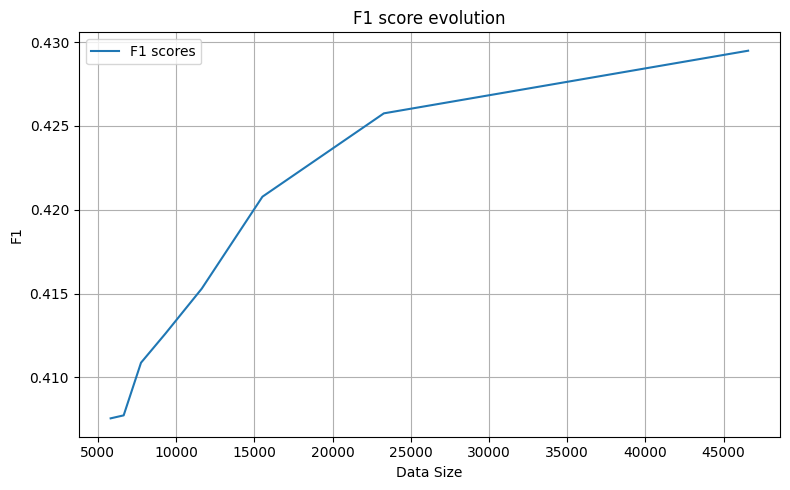

Summary:

Max F1 score 0.42949003628955196
Min validation loss 0.47528220773735663


In [97]:
data_sizes = np.array([N / (len(train_losses) - i) for i in range(len(train_losses))])

plt.figure(figsize=(8, 5))
plt.plot(data_sizes, f1s_datasize, label='F1 scores')


plt.xlabel('Data Size')
plt.ylabel('F1')
plt.title('F1 score evolution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Summary:\n")
print("Max F1 score", np.max(f1s_datasize))
print("Min validation loss", np.min(val_losses))

Results seem much better, but let's do anyways a cross-validation

In [ ]:
# Cross-validation with the best parameters found until now. Lambda and alpha from Model_I and alpha from model_II

acc_feature_type, f1_feature_type = kfold_logistic_ridge(
        X_train_data, Y_train_data, preprocess_feature_types, k=5,
        gamma=0.2, lambda_=1e-6, alpha = 0.7,
        threshold=1e-6, random_state=True)

Start cleaning batch 1 out of 5
Number of features before one-hot encoder: 203
Number of features after one-hot encoder: 486
Cleaning of batch 1 done. Stating the model training.
Iteration     0, loss = 0.693147
Iteration   100, loss = 0.480515
Iteration   200, loss = 0.473160
Iteration   300, loss = 0.469582
Iteration   400, loss = 0.467377
Iteration   500, loss = 0.465888
Iteration   600, loss = 0.464828
Iteration   700, loss = 0.464044
Iteration   800, loss = 0.463445
Iteration   900, loss = 0.462976
Iteration  1000, loss = 0.462601
Iteration  1100, loss = 0.462295
Iteration  1200, loss = 0.462042
Iteration  1300, loss = 0.461828
Iteration  1400, loss = 0.461646
Iteration  1500, loss = 0.461489
Iteration  1600, loss = 0.461352
Iteration  1700, loss = 0.461231
Iteration  1800, loss = 0.461124
Converged at iteration 1810
 Accuracy: 85.99%
 F1 Score: 0.4285
     from now, f1 score: 0.4285359184688039 accuracy: 0.859874746674387
Start cleaning batch 2 out of 5
Number of features before 

In [114]:
# Stored resultsof the cross-validation print

print("5 folds cross-validation got F1 score for Feature Type Separation model 0.42468603771133767 and accuracy 0.8597802733630975")

5 folds cross-validation got F1 score for Feature Type Separation model 0.42468603771133767 and accuracy 0.8597802733630975


From now, is the model with the best performance, but let's try to improve it. As we see in the learning curve diagram, the F1 score keeps going up for more datapoints. Now we are not underfitting, but maybe, as we eliminate datapoints in order to balance the labels, we are not using all the information provided. Let's try to improve this.

# Weighted logistic model
To use all datapoints, instead of balancing the labels, we will give diferent weights to the labels. 

In [7]:
# Same preprocessing as the last model, but without balancing

def preprocess_weighted_logistic(X_train, X_valid, Y_train, Y_valid):
    """
    Args:
        X_train: data as it is loaded from csv. No balanced labels
        Y_train: labels 1 and 0 without balance. 
        X_valid: data as it is loaded from csv. No balanced labels
        Y_valid: labels 1 and 0 without balance. 

    Returns:
        X_train_preprocessed: 
        Y_train_preprocessed: 
        X_valid_preprocessed: 
        Y_valid_preprocessed: 
    """

    # Tuning parameter section
    NaN_removal_threshold = 0.75

    # Remove high desnity NaN features

    X_train, NaN_removal_features_mask = remove_nan_features(X_train, threshold=NaN_removal_threshold)

    # Detect categorical
    X_valid = X_valid[:, NaN_removal_features_mask]
    cat_mask, num_mask = detect_features_type(X_train, max_unique=10)

    # Numerical NaN substitution with means
    
    X_train, means = impute_numerical(X_train, num_mask, strategy= 'means')
    X_valid, _ = impute_numerical(X_valid, num_mask, means = means, strategy = 'means')

    # Categorical NaN substitution (compute modes from training)
    X_train, modes = impute_categorical(X_train, cat_mask)
    X_valid, _ = impute_categorical(X_valid, cat_mask, modes)

    # Fit one-hot encoder on training data. Now we are adding features

    print("Number of features before one-hot encoder:", X_train.shape[1])
    X_train, categories = one_hot_encode(X_train, cat_mask, drop_first=True)
    X_valid, _ = one_hot_encode(X_valid, cat_mask, categories, drop_first=True)
    print("Number of features after one-hot encoder:", X_train.shape[1])

    cat_mask_enc, num_mask_enc = detect_features_type(X_train, max_unique=10)

    # standarize only the numerical features
    X_train, means, stds = standardize_features(X_train, num_mask_enc)
    X_valid, _, _ = standardize_features(X_valid, num_mask_enc, means, stds)

    return X_train, X_valid, Y_train, Y_valid

In [ ]:
# Cross-validation for the weigthed model

N_pos = np.sum(Y_train_data == 1)
N_neg = np.sum(Y_train_data == 0)
pos_weight = N_neg / N_pos
neg_weight = 1.0

# set the best parameters until now

acc_weighted, f1_weighted = kfold_logistic_ridge_weighted(  
        X_train_data, Y_train_data, preprocess_weighted_logistic, k=2,
        pos_weight=pos_weight, neg_weight=neg_weight, clip_grad=10.0,
        gamma=0.2, lambda_=1e-6, alpha = 0.7,
        threshold=1e-7, random_state=True)

Start cleaning batch 1 out of 2
Number of features before one-hot encoder: 204
Number of features after one-hot encoder: 479
Cleaning of batch 1 done. Stating the model training.
Iter     0 | Loss = 0.693147 | GradNorm = 0.5882
Iter   100 | Loss = 0.479683 | GradNorm = 0.0233
Iter   200 | Loss = 0.473102 | GradNorm = 0.0145
Iter   300 | Loss = 0.469925 | GradNorm = 0.0110
Iter   400 | Loss = 0.467969 | GradNorm = 0.0089
Iter   500 | Loss = 0.466651 | GradNorm = 0.0074
Iter   600 | Loss = 0.465712 | GradNorm = 0.0063
Iter   700 | Loss = 0.465018 | GradNorm = 0.0055
Iter   800 | Loss = 0.464490 | GradNorm = 0.0048
Iter   900 | Loss = 0.464077 | GradNorm = 0.0043
Iter  1000 | Loss = 0.463748 | GradNorm = 0.0038
Iter  1100 | Loss = 0.463481 | GradNorm = 0.0035
Iter  1200 | Loss = 0.463260 | GradNorm = 0.0032
Iter  1300 | Loss = 0.463075 | GradNorm = 0.0029
Iter  1400 | Loss = 0.462917 | GradNorm = 0.0027
Iter  1500 | Loss = 0.462782 | GradNorm = 0.0025
Iter  1600 | Loss = 0.462665 | GradNo

In [89]:
# print the stored results of the cross validation

print("For 5 folds cross-validation weighted logistic: accuracy 0.8607890045255765 and F1 score 0.42614768007922593")

For 5 folds cross-validation weighted logistic: accuracy 0.8607890045255765 and F1 score 0.42614768007922593


## Learning curve
Plot the learning curve to see what is happening.

In [100]:
# Define train method and evaluator. We use the best parameters seen until now.


def train_method(y, x):  

    N_pos = np.sum(y == 1)
    N_neg = np.sum(y == 0)
    pos_weight = N_neg / N_pos
    neg_weight = 1.0

    return logistic_regression_weighted_gd(
            y, x, lambda_=1e-6, gamma=0.2, pos_weight=pos_weight, neg_weight=neg_weight,
            max_iter=10000, tol=1e-6)
    # Set lambda 1e-6 due to Model_I
    # Set gamma = 0.2 as we saw it beahaved like 0.1 and makes the training faster
    
def evaluator(y, x, w):
    return evaluate_logistic_model(y, x, w, threshold=0.7, lambda_ = 1e-6) 
    # Set alpha threshold 70% due to Model_I

In [108]:
#This cell takes some time to run. Better run the one below to load the results

m = X_train_data.shape[0] // 5
X_train_over, X_val_over = X_train_data[m:], X_train_data[:m]
Y_train_over, Y_val_over = Y_train_data[m:], Y_train_data[:m]


train_losses_weighted, val_losses_weighted, f1s_weighted, N = over_under_fitting(
    X_train_over, 
    X_val_over, 
    Y_train_over, 
    Y_val_over, 
    train_method = train_method, 
    evaluator = evaluator, preprocess=preprocess_weighted_logistic, steps = 10)

Before preprocess (262508, 321) (262508,)
Number of features before one-hot encoder: 204
Number of features after one-hot encoder: 472
After preprocess (262508, 472) (262508,)
n_i 26250
Iter     0 | Loss = 0.693147 | GradNorm = 0.5571
Iter   100 | Loss = 0.474278 | GradNorm = 0.0257
Iter   200 | Loss = 0.465937 | GradNorm = 0.0166
Iter   300 | Loss = 0.461745 | GradNorm = 0.0127
Iter   400 | Loss = 0.459134 | GradNorm = 0.0103
Iter   500 | Loss = 0.457353 | GradNorm = 0.0086
Iter   600 | Loss = 0.456064 | GradNorm = 0.0074
Iter   700 | Loss = 0.455090 | GradNorm = 0.0065
Iter   800 | Loss = 0.454329 | GradNorm = 0.0058
Iter   900 | Loss = 0.453715 | GradNorm = 0.0053
Iter  1000 | Loss = 0.453208 | GradNorm = 0.0048
Iter  1100 | Loss = 0.452780 | GradNorm = 0.0044
Iter  1200 | Loss = 0.452412 | GradNorm = 0.0041
Iter  1300 | Loss = 0.452091 | GradNorm = 0.0039
Iter  1400 | Loss = 0.451807 | GradNorm = 0.0037
Iter  1500 | Loss = 0.451553 | GradNorm = 0.0035
Iter  1600 | Loss = 0.451322 |

In [ ]:
# Storing the results cell

"""
print(train_losses_weighted, val_losses_weighted, f1s_weighted)

l1 = np.array(train_losses_weighted)
l2 = np.array(val_losses_weighted)
l3 = np.array(f1s_weighted)

np.savez('LearningCurveWeighted.npz', a=l1, b=l2, c=l3)
"""

[0.4492849411367531, 0.45177798915046735, 0.45203042066953397, 0.45251892545406647, 0.452682876229165, 0.4532848139004807, 0.45352863558837, 0.45465378714110344, 0.45835827204045926, 0.46210616404592014] [0.4769056625568624, 0.47772344518250326, 0.47617833014453503, 0.47550581666082015, 0.4746387964045717, 0.4739482279102421, 0.4726142794257909, 0.4695339094544039, 0.47081015930949116, 0.4731306151810819] [np.float64(0.42018615842461804), np.float64(0.41708131259053927), np.float64(0.4192470202434252), np.float64(0.41690888411474747), np.float64(0.4200214877077667), np.float64(0.4198950894267834), np.float64(0.42211055276381865), np.float64(0.4238783075546461), np.float64(0.4253271747498071), np.float64(0.4276640790402254)]


In [110]:
# Load the results

m = X_train_data.shape[0] // 5
X_train_over, X_val_over = X_train_data[m:], X_train_data[:m]
Y_train_over, Y_val_over = Y_train_data[m:], Y_train_data[:m]
X_train_over, X_val_over, _, _  = preprocess_weighted_logistic(X_train_over, X_val_over, Y_train_over, Y_val_over)

N = X_train_over.shape[0] # The largest datasize used in the learning curve generator

data = np.load('LearningCurveWeighted.npz')
train_losses_weighted_loaded = data['a']
val_losses_weighted_loaded = data['b']
f1s_weighted_loaded = data['c']


Number of features before one-hot encoder: 204
Number of features after one-hot encoder: 472


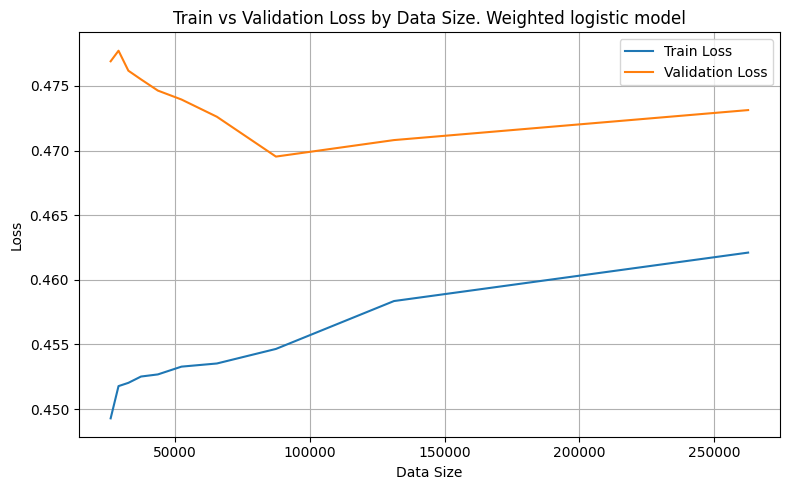

In [111]:
data_sizes = np.array([N / (len(train_losses_weighted_loaded) - i) for i in range(len(train_losses_weighted_loaded))])

plt.figure(figsize=(8, 5))
plt.plot(data_sizes, train_losses_weighted_loaded, label='Train Loss')
plt.plot(data_sizes, val_losses_weighted_loaded, label='Validation Loss')


plt.xlabel('Data Size')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss by Data Size. Weighted logistic model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

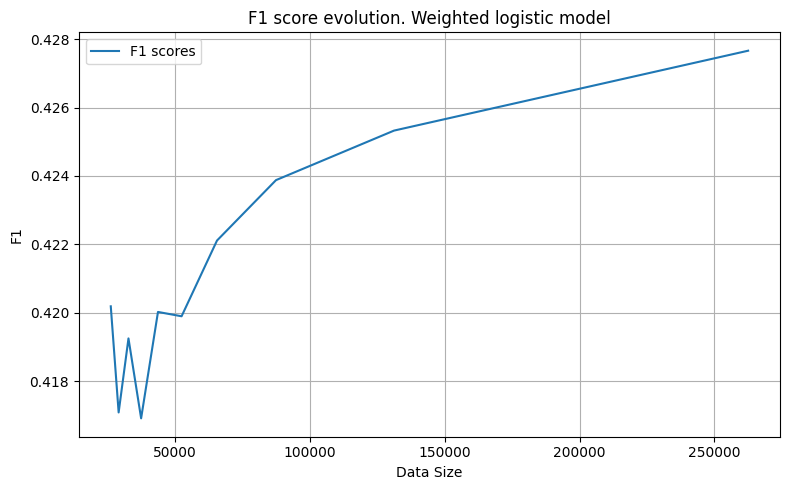

Summary Weighted Logistic Model:

Max F1 score 0.4276640790402254 for number of datapoints: 262508.0
Min validation loss 0.4695339094544039


In [113]:
data_sizes = np.array([N / (len(train_losses_weighted_loaded) - i) for i in range(len(train_losses_weighted_loaded))])

plt.figure(figsize=(8, 5))
plt.plot(data_sizes, f1s_weighted_loaded, label='F1 scores')


plt.xlabel('Data Size')
plt.ylabel('F1')
plt.title('F1 score evolution. Weighted logistic model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Summary Weighted Logistic Model:\n")
print("Max F1 score", np.max(f1s_weighted_loaded), "for number of datapoints:", data_sizes[np.argmax(f1s_weighted_loaded)])
print("Min validation loss", np.min(val_losses_weighted_loaded))

Best model from now, acording to cross-validations F1 scores, the last one: the weighted logistic model
Best F1 score until now = 0.4276640790402254

# Correlation 
Not all the features we are using are relevant for our model (just check the features description webside), so in this section we will use statistical tools to try to select the best features.

## Correlation with the output without training
First, we will try to remove the features with low correlation with the output before the training

In [ ]:
# Same as the last model, but with the correlation y 

def preprocess_weighted_y_correlation(X_train, X_valid, Y_train, Y_valid):
    """
    Args:
        X_train: data as it is loaded from csv. No balanced labels
        Y_train: labels 1 and 0 without balance. 
        X_valid: data as it is loaded from csv. No balanced labels
        Y_valid: labels 1 and 0 without balance. 

    Returns:
        X_train_preprocessed: 
        Y_train_preprocessed: 
        X_valid_preprocessed: 
        Y_valid_preprocessed: 
    """

    # Tuning parameter section
    NaN_removal_threshold = 0.75

    # Remove high desnity NaN features

    X_train, NaN_removal_features_mask = remove_nan_features(X_train, threshold=NaN_removal_threshold)
    X_valid = X_valid[:, NaN_removal_features_mask]


    # Detect categorical

    cat_mask, num_mask = detect_features_type(X_train, max_unique=10)

    # Numerical NaN substitution with means
    
    X_train, means = impute_numerical(X_train, num_mask, strategy= 'means')
    X_valid, _ = impute_numerical(X_valid, num_mask, means = means, strategy = 'means')

    # Categorical NaN substitution (compute modes from training)
    X_train, modes = impute_categorical(X_train, cat_mask)
    X_valid, _ = impute_categorical(X_valid, cat_mask, modes)

    # Fit one-hot encoder on training data. Now we are adding features

    print("Number of features before one-hot encoder:", X_train.shape[1])
    X_train, categories = one_hot_encode(X_train, cat_mask, drop_first=True)
    X_valid, _ = one_hot_encode(X_valid, cat_mask, categories, drop_first=True)
    print("Number of features after one-hot encoder:", X_train.shape[1])

    cat_mask_enc, num_mask_enc = detect_features_type(X_train, max_unique=10)
        
    # standardize only the numerical features
    X_train, means, stds = standardize_features(X_train, num_mask_enc)
    X_valid, _, _ = standardize_features(X_valid, num_mask_enc, means, stds)

    # Remove low correlation with the output features
    # Doesn't matter if we do it after standardize

    print("Numerical features before output correlation elimination", np.sum(num_mask_enc))
    print("Categorical features before output correlation elimination", np.sum(cat_mask_enc))

    low_corr_y_mask = feature_target_correlation(X_train, Y_train, threshold_elimination=0.05) # we do
    X_train = X_train[:, low_corr_y_mask]
    X_valid = X_valid[:, low_corr_y_mask]

    cat_mask_final, num_mask_final = detect_features_type(X_train, max_unique=10)

    print("Numerical features before output correlation elimination", np.sum(num_mask_final))
    print("Categorical features before output correlation elimination", np.sum(cat_mask_final))

    # Check feature elimination befor and after
    

    return X_train, X_valid, Y_train, Y_valid

In [129]:
# Check dimensionality change 

m = X_train_data.shape[0] // 5
X_train_over, X_val_over = X_train_data[m:], X_train_data[:m]
Y_train_over, Y_val_over = Y_train_data[m:], Y_train_data[:m]


print("Shapes before preprocessing", X_train_over.shape, Y_train_over.shape)
X1, X2, Y1, Y2 = preprocess_weighted_y_correlation(
    X_train_over,  
    X_val_over, 
    Y_train_over,
    Y_val_over)
print("Shapes after preprocessing", X1.shape, X2.shape, Y1.shape, Y2.shape)

N = X1.shape[0]

Shapes before preprocessing (262508, 321) (262508,)
Number of features before one-hot encoder: 204
Number of features after one-hot encoder: 472
Numerical features before output correlation elimination 78
Categorical features before output correlation elimination 394
Numerical features before output correlation elimination 12
Categorical features before output correlation elimination 86
Shapes after preprocessing (262508, 98) (65627, 98) (262508,) (65627,)


Shapes before preprocessing (262508, 321) (262508,)
Number of features before one-hot encoder: 204
Number of features after one-hot encoder: 472
Shapes after preprocessing (262508, 472) (65627, 472) (262508,) (65627,)

In [146]:
# Cross-validation for the weigthed model

N_pos = np.sum(Y_train_data == 1)
N_neg = np.sum(Y_train_data == 0)
pos_weight = N_neg / N_pos
neg_weight = 1.0

# set the best parameters until now

acc_weighted_y_corr, f1_weighted_y_corr = kfold_logistic_ridge_weighted(  
        X_train_data, Y_train_data, preprocess_weighted_y_correlation, k=3,
        pos_weight=pos_weight, neg_weight=neg_weight, clip_grad=10.0,
        gamma=0.4, lambda_=1e-6, alpha = 0.7,
        threshold=1e-7, random_state=True)

Start cleaning batch 1 out of 3
Number of features before one-hot encoder: 204
Number of features after one-hot encoder: 480
Numerical features before output correlation elimination 77
Categorical features before output correlation elimination 403
Numerical features before output correlation elimination 8
Categorical features before output correlation elimination 90
Cleaning of batch 1 done. Stating the model training.
Iter     0 | Loss = 0.693147 | GradNorm = 0.5211
Iter   100 | Loss = 0.477847 | GradNorm = 0.0133
Iter   200 | Loss = 0.473823 | GradNorm = 0.0076
Iter   300 | Loss = 0.472234 | GradNorm = 0.0052
Iter   400 | Loss = 0.471412 | GradNorm = 0.0039
Iter   500 | Loss = 0.470917 | GradNorm = 0.0031
Iter   600 | Loss = 0.470586 | GradNorm = 0.0026
Iter   700 | Loss = 0.470349 | GradNorm = 0.0023
Iter   800 | Loss = 0.470170 | GradNorm = 0.0020
Iter   900 | Loss = 0.470028 | GradNorm = 0.0018
Iter  1000 | Loss = 0.469914 | GradNorm = 0.0016
Iter  1100 | Loss = 0.469819 | GradNor

In [147]:
print("For the weighted model eliminating low correlation with the output we get, after cross-validation:")
print("F1 score:", f1_weighted_y_corr)
print("Accuracy", acc_weighted_y_corr)

For the weighted model eliminating low correlation with the output we get, after cross-validation:
F1 score: 0.4216093635174258
Accuracy 0.8617337374315812


As we see, removing the correlation with the output is not improving our model (check the last model's F1 score and compare). So, the best from now is the Weighted Logistic Model. Let's try now to remove correlations in the training set, as it seems that we don't need features that behave the same

## Correlation between features removal

In [71]:
# Same as the weighted model, but with feature selection based on the correlation between features

def preprocess_weighted_x_correlation(X_train, X_valid, Y_train, Y_valid):
    """
    Args:
        X_train: data as it is loaded from csv. No balanced labels
        Y_train: labels 1 and 0 without balance. 
        X_valid: data as it is loaded from csv. No balanced labels
        Y_valid: labels 1 and 0 without balance. 

    Returns:
        X_train_preprocessed: 
        Y_train_preprocessed: 
        X_valid_preprocessed: 
        Y_valid_preprocessed: 
    """

    # Tuning parameter section
    NaN_removal_threshold = 0.75

    # Remove high desnity NaN features

    X_train, NaN_removal_features_mask = remove_nan_features(X_train, threshold=NaN_removal_threshold)
    X_valid = X_valid[:, NaN_removal_features_mask]


    # Detect categorical

    cat_mask, num_mask = detect_features_type(X_train, max_unique=10)

    # Numerical NaN substitution with means
    
    X_train, means = impute_numerical(X_train, num_mask, strategy= 'means')
    X_valid, _ = impute_numerical(X_valid, num_mask, means = means, strategy = 'means')

    # Categorical NaN substitution (compute modes from training)
    X_train, modes = impute_categorical(X_train, cat_mask)
    X_valid, _ = impute_categorical(X_valid, cat_mask, modes)

    # Fit one-hot encoder on training data. Now we are adding features

    print("Number of features before one-hot encoder:", X_train.shape[1])
    X_train, categories = one_hot_encode(X_train, cat_mask, drop_first=True)
    X_valid, _ = one_hot_encode(X_valid, cat_mask, categories, drop_first=True)
    print("Number of features after one-hot encoder:", X_train.shape[1])

    cat_mask_enc, num_mask_enc = detect_features_type(X_train, max_unique=10)
        
    # standardize only the numerical features
    X_train, means, stds = standardize_features(X_train, num_mask_enc)
    X_valid, _, _ = standardize_features(X_valid, num_mask_enc, means, stds)

    # Remove high correlation between features
    # Doesn't matter if we do it after standardize

    print("Numerical features before correlation elimination", np.sum(num_mask_enc))
    print("Categorical features before correlation elimination", np.sum(cat_mask_enc))

    corr_y = feature_target_correlation(X_train, Y_train)
    corr_mat = correlation_matrix(X_train)
    corr_threshold = 0.9
    to_drop = set()

    for i in range(corr_mat.shape[0]):
        for j in range(i + 1, corr_mat.shape[1]):
            if abs(corr_mat[i, j]) > corr_threshold:
                # Compare absolute correlation with y
                if abs(corr_y[i]) < abs(corr_y[j]):
                    to_drop.add(i)
                else:
                    to_drop.add(j)

    keep_mask_inter = np.ones(X_train.shape[1], dtype=bool)
    keep_mask_inter[list(to_drop)] = False

    X_train = X_train[:, keep_mask_inter]
    X_valid = X_valid[:, keep_mask_inter]


    cat_mask_final, num_mask_final = detect_features_type(X_train, max_unique=10)

    print("Numerical features after correlation elimination", np.sum(num_mask_final))
    print("Categorical features after correlation elimination", np.sum(cat_mask_final))

    # Check feature elimination befor and after

    return X_train, X_valid, Y_train, Y_valid

In [77]:
# Cross-validation for the weigthed model

N_pos = np.sum(Y_train_data == 1)
N_neg = np.sum(Y_train_data == 0)
pos_weight = N_neg / N_pos
neg_weight = 1.0


# set the best parameters until now

acc_weighted_x_corr, f1_weighted_x_corr = kfold_logistic_ridge_weighted(  
        X_train_data, Y_train_data, preprocess_weighted_x_correlation, k=3,
        pos_weight=pos_weight, neg_weight=neg_weight, clip_grad=10.0,
        gamma=0.2, lambda_=1e-6, alpha = 0.73,
        threshold=1e-7, random_state=True)

Start cleaning batch 1 out of 3
Number of features before one-hot encoder: 204
Number of features after one-hot encoder: 480
Numerical features before correlation elimination 77
Categorical features before correlation elimination 403
Numerical features after correlation elimination 67
Categorical features after correlation elimination 322
Cleaning of batch 1 done. Stating the model training.
Iter     0 | Loss = 0.693147 | GradNorm = 0.4577
Iter   100 | Loss = 0.481996 | GradNorm = 0.0272
Iter   200 | Loss = 0.473573 | GradNorm = 0.0156
Iter   300 | Loss = 0.470055 | GradNorm = 0.0113
Iter   400 | Loss = 0.467999 | GradNorm = 0.0091
Iter   500 | Loss = 0.466628 | GradNorm = 0.0075
Iter   600 | Loss = 0.465654 | GradNorm = 0.0064
Iter   700 | Loss = 0.464932 | GradNorm = 0.0056
Iter   800 | Loss = 0.464382 | GradNorm = 0.0049
Iter   900 | Loss = 0.463952 | GradNorm = 0.0044
Iter  1000 | Loss = 0.463608 | GradNorm = 0.0039
Iter  1100 | Loss = 0.463329 | GradNorm = 0.0036
Iter  1200 | Loss

In [79]:

N_pos = np.sum(Y_train_data == 1)
N_neg = np.sum(Y_train_data == 0)
pos_weight = N_neg / N_pos
neg_weight = 1.0

X_train, X_valid, Y_train, Y_valid = preprocess_weighted_x_correlation(
    X_train_data, X_test_data, Y_train_data, Y_train_data)

loss, w_final = logistic_regression_weighted_gd(
            Y_train, X_train, lambda_=1e-6, gamma=0.2, pos_weight=pos_weight, neg_weight=neg_weight,
            max_iter=10000, tol=1e-7, clip_grad=10.0, verbose=True)

Number of features before one-hot encoder: 204
Number of features after one-hot encoder: 472
Numerical features before correlation elimination 78
Categorical features before correlation elimination 394
Numerical features after correlation elimination 68
Categorical features after correlation elimination 313
Iter     0 | Loss = 0.693147 | GradNorm = 0.4583
Iter   100 | Loss = 0.482093 | GradNorm = 0.0271
Iter   200 | Loss = 0.473797 | GradNorm = 0.0154
Iter   300 | Loss = 0.470366 | GradNorm = 0.0112
Iter   400 | Loss = 0.468362 | GradNorm = 0.0090
Iter   500 | Loss = 0.467021 | GradNorm = 0.0075
Iter   600 | Loss = 0.466066 | GradNorm = 0.0064
Iter   700 | Loss = 0.465357 | GradNorm = 0.0055
Iter   800 | Loss = 0.464815 | GradNorm = 0.0049
Iter   900 | Loss = 0.464391 | GradNorm = 0.0043
Iter  1000 | Loss = 0.464052 | GradNorm = 0.0039
Iter  1100 | Loss = 0.463776 | GradNorm = 0.0035
Iter  1200 | Loss = 0.463549 | GradNorm = 0.0032
Iter  1300 | Loss = 0.463358 | GradNorm = 0.0030
Iter 